<a href="https://colab.research.google.com/github/weswest/SnailStocks/blob/main/SnailStocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Simple Stock Market Game - Strategy Testing Framework
# Cell 1: Setup

import numpy as np
import pandas as pd
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
from copy import deepcopy
from scipy import stats

print("Loading Simple Stock Market Strategy Framework...")

# ==================== CORE GAME COMPONENTS ====================

class Movement(Enum):
    BEARISH = 0    # -5% to -8%
    DOWNWARD = 1   # -2% to -5%
    UNCERTAIN = 2  # -2% to +2%
    UPWARD = 3     # +2% to +5%
    BULLISH = 4    # +5% to +8%

@dataclass
class GameConfig:
    n_stocks: int = 6
    n_days: int = 7
    initial_price: float = 100.0
    initial_cash: float = 300_000.0  # Changed from 330k
    lot_size: int = 100

    movement_ranges: Dict[Movement, Tuple[float, float]] = field(default_factory=lambda: {
        Movement.BEARISH: (-0.08, -0.05),
        Movement.DOWNWARD: (-0.05, -0.02),
        Movement.UNCERTAIN: (-0.02, 0.02),
        Movement.UPWARD: (0.02, 0.05),
        Movement.BULLISH: (0.05, 0.08)
    })

    movement_probs: List[float] = field(default_factory=lambda: [0.2, 0.2, 0.2, 0.2, 0.2])

@dataclass
class GameState:
    day: int
    cash: float
    holdings: np.ndarray
    prices: np.ndarray
    tomorrows_movements: np.ndarray

    def get_portfolio_value(self) -> float:
        return self.cash + np.sum(self.holdings * self.prices)

class StockMarketGame:
    def __init__(self, config: GameConfig = GameConfig(), seed: Optional[int] = None):
        self.config = config
        self.rng = np.random.RandomState(seed)
        self.reset()

    def reset(self) -> GameState:
        self.day = 1
        self.cash = self.config.initial_cash
        self.holdings = np.zeros(self.config.n_stocks, dtype=int)
        self.prices = np.full(self.config.n_stocks, self.config.initial_price)
        self.price_history = [self.prices.copy()]
        self.movement_history = []

        tomorrows_movements = self._generate_movements()

        self.state = GameState(
            day=self.day,
            cash=self.cash,
            holdings=self.holdings.copy(),
            prices=self.prices.copy(),
            tomorrows_movements=tomorrows_movements
        )

        return self.state

    def _generate_movements(self) -> np.ndarray:
        movements = self.rng.choice(
            list(Movement),
            size=self.config.n_stocks,
            p=self.config.movement_probs
        )
        return np.array([m.value for m in movements])

    def _apply_movement(self, stock_idx: int, movement: Movement) -> float:
        min_change, max_change = self.config.movement_ranges[movement]
        change = self.rng.uniform(min_change, max_change)
        return self.prices[stock_idx] * (1 + change)

    def step(self, actions: Dict[int, int]) -> Tuple[GameState, float, bool]:
        # Execute purchases
        for stock_idx, n_lots in actions.items():
            if n_lots > 0:
                shares = n_lots * self.config.lot_size
                cost = shares * self.prices[stock_idx]

                if cost <= self.cash:
                    self.cash -= cost
                    self.holdings[stock_idx] += shares
                else:
                    affordable_lots = int(self.cash / (self.config.lot_size * self.prices[stock_idx]))
                    if affordable_lots > 0:
                        shares = affordable_lots * self.config.lot_size
                        cost = shares * self.prices[stock_idx]
                        self.cash -= cost
                        self.holdings[stock_idx] += shares

        # Apply price movements
        self.movement_history.append(self.state.tomorrows_movements.copy())
        for i in range(self.config.n_stocks):
            movement = Movement(self.state.tomorrows_movements[i])
            self.prices[i] = self._apply_movement(i, movement)

        self.price_history.append(self.prices.copy())
        self.day += 1

        done = self.day > self.config.n_days

        if done:
            final_value = self.cash + np.sum(self.holdings * self.prices)
            reward = final_value - self.config.initial_cash
        else:
            reward = 0.0
            tomorrows_movements = self._generate_movements()

            self.state = GameState(
                day=self.day,
                cash=self.cash,
                holdings=self.holdings.copy(),
                prices=self.prices.copy(),
                tomorrows_movements=tomorrows_movements
            )

        return self.state, reward, done

    def get_valid_actions(self, state: GameState) -> Dict[int, int]:
        valid_actions = {}
        for i in range(self.config.n_stocks):
            max_lots = int(state.cash / (self.config.lot_size * state.prices[i]))
            if max_lots > 0:
                valid_actions[i] = max_lots
        return valid_actions

# ==================== FLEXIBLE STRATEGY CLASS ====================

class FlexibleStrategy:
    """
    A flexible strategy defined by:
    - capital_deployment: array of target % of initial capital to deploy each day
    - multi_stock_multiplier: multiplier when >1 bullish stock (e.g., 1.5 = 50% more)
    """
    def __init__(self, name: str, capital_deployment: List[float], multi_stock_multiplier: float = 1.0):
        self.name = name
        self.capital_deployment = capital_deployment
        self.multi_stock_multiplier = multi_stock_multiplier
        self.initial_capital = None

    def decide(self, state: GameState, valid_actions: Dict[int, int], config: GameConfig) -> Dict[int, int]:
        if self.initial_capital is None:
            self.initial_capital = config.initial_cash

        actions = {}

        # Get today's deployment percentage
        if state.day <= len(self.capital_deployment):
            base_deployment_pct = self.capital_deployment[state.day - 1]
        else:
            base_deployment_pct = 0.0

        if base_deployment_pct == 0:
            return actions

        # Find bullish stocks
        bullish_stocks = np.where(state.tomorrows_movements == Movement.BULLISH.value)[0]
        n_bullish = len(bullish_stocks)

        if n_bullish == 0:
            return actions

        # Apply multiplier if multiple bullish stocks
        if n_bullish > 1 and self.multi_stock_multiplier > 1.0:
            deployment_pct = base_deployment_pct * self.multi_stock_multiplier
            # Cap at 100% of current cash
            deployment_pct = min(deployment_pct, state.cash / self.initial_capital)
        else:
            deployment_pct = base_deployment_pct

        # Calculate total capital to deploy
        capital_to_deploy = state.cash * deployment_pct
        capital_to_deploy = min(capital_to_deploy, state.cash)  # Can't spend more than we have

        # Distribute equally among bullish stocks
        capital_per_stock = capital_to_deploy / n_bullish

        for stock_idx in bullish_stocks:
            if stock_idx in valid_actions:
                desired_lots = int(capital_per_stock / (state.prices[stock_idx] * config.lot_size))
                actions[stock_idx] = min(desired_lots, valid_actions[stock_idx])

        return actions

# ==================== STRATEGY DEFINITIONS ====================

def create_strategies() -> List[FlexibleStrategy]:
    """Create all 7 strategies to test"""
    strategies = []

    # 1. Buy First Bullish (100% on day 1)
    strategies.append(FlexibleStrategy(
        name="Buy First Bullish",
        capital_deployment=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
    ))

    # 2. Threshold Day 4+
    strategies.append(FlexibleStrategy(
        name="Threshold Day 4+",
        capital_deployment=[0, 0, 0, 1.0, 1.0, 1.0, 1.0]
    ))

    # 3. Threshold Day 5+
    strategies.append(FlexibleStrategy(
        name="Threshold Day 5+",
        capital_deployment=[0, 0, 0, 0, 1.0, 1.0, 1.0]
    ))

    # 4. Simple Fractional (1/days_remaining starting from day 1)
    # Day 1: 1/7, Day 2: 1/6, Day 3: 1/5, etc.
    simple_fractional = []
    for day in range(1, 8):
        days_remaining = 8 - day
        if days_remaining > 0:
            simple_fractional.append(1.0 / days_remaining)
        else:
            simple_fractional.append(0)
    strategies.append(FlexibleStrategy(
        name="Simple Fractional",
        capital_deployment=simple_fractional
    ))

    # 5. Fractional with Cutoff (nothing days 1-3, then 1/days_remaining)
    fractional_cutoff = []
    for day in range(1, 8):
        if day <= 3:
            fractional_cutoff.append(0)
        else:
            days_remaining = 8 - day
            if days_remaining > 0:
                fractional_cutoff.append(1.0 / days_remaining)
            else:
                fractional_cutoff.append(0)
    strategies.append(FlexibleStrategy(
        name="Fractional with Cutoff",
        capital_deployment=fractional_cutoff
    ))

    # 6. Simple Fractional with Multiplier
    strategies.append(FlexibleStrategy(
        name="Fractional + 50% Multi",
        capital_deployment=simple_fractional,
        multi_stock_multiplier=1.5
    ))

    # 7. Fractional with Cutoff and Multiplier
    strategies.append(FlexibleStrategy(
        name="Cutoff + 50% Multi",
        capital_deployment=fractional_cutoff,
        multi_stock_multiplier=1.5
    ))

    return strategies

# ==================== SIMULATION AND ANALYSIS ====================

@dataclass
class Episode:
    strategy_name: str
    final_return: float
    daily_values: List[float]
    decisions: List[Tuple[int, Dict[int, int]]]  # (day, actions)

class Simulator:
    def __init__(self, config: GameConfig = GameConfig()):
        self.config = config

    def run_episode(self, strategy: FlexibleStrategy, seed: int = None) -> Episode:
        game = StockMarketGame(self.config, seed=seed)
        state = game.reset()

        daily_values = [state.get_portfolio_value()]
        decisions = []

        done = False
        while not done:
            valid_actions = game.get_valid_actions(state)
            actions = strategy.decide(state, valid_actions, self.config)
            decisions.append((state.day, actions))

            state, reward, done = game.step(actions)
            daily_values.append(state.get_portfolio_value())

        return Episode(
            strategy_name=strategy.name,
            final_return=reward,
            daily_values=daily_values,
            decisions=decisions
        )

    def evaluate_strategy(self, strategy: FlexibleStrategy, n_episodes: int = 1000) -> Dict:
        """Run many episodes and compute statistics"""
        returns = []

        for i in range(n_episodes):
            episode = self.run_episode(strategy, seed=i)
            returns.append(episode.final_return)

        returns = np.array(returns)

        # Calculate confidence interval
        mean_return = np.mean(returns)
        std_error = stats.sem(returns)
        ci = stats.t.interval(0.95, len(returns)-1, loc=mean_return, scale=std_error)

        return {
            'strategy': strategy.name,
            'mean_return': mean_return,
            'std_dev': np.std(returns),
            'sharpe_ratio': mean_return / np.std(returns) if np.std(returns) > 0 else 0,
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'positive_rate': np.mean(returns > 0),
            'returns': returns
        }

# ==================== VISUALIZATION ====================

def plot_strategy_comparison(results: List[Dict]):
    """Create a clean comparison plot focused on mean returns and Sharpe ratios"""
    # Create DataFrame for easier plotting
    df = pd.DataFrame([{
        'Strategy': r['strategy'],
        'Mean Return': r['mean_return'],
        'Sharpe Ratio': r['sharpe_ratio'],
        'CI Lower': r['ci_lower'],
        'CI Upper': r['ci_upper']
    } for r in results])

    # Sort by mean return
    df = df.sort_values('Mean Return', ascending=False)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Mean Returns with Confidence Intervals
    x = np.arange(len(df))
    ax1.bar(x, df['Mean Return'], color='steelblue', alpha=0.8)

    # Add error bars for confidence intervals
    errors = [df['Mean Return'] - df['CI Lower'], df['CI Upper'] - df['Mean Return']]
    ax1.errorbar(x, df['Mean Return'], yerr=errors, fmt='none', color='black', capsize=5)

    ax1.set_xticks(x)
    ax1.set_xticklabels(df['Strategy'], rotation=45, ha='right')
    ax1.set_ylabel('Mean Return ($)')
    ax1.set_title('Expected Returns with 95% Confidence Intervals')
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (idx, row) in enumerate(df.iterrows()):
        ax1.text(i, row['Mean Return'] + 500, f"${row['Mean Return']:,.0f}",
                ha='center', va='bottom', fontsize=9)

    # Plot 2: Sharpe Ratios
    ax2.bar(x, df['Sharpe Ratio'], color='darkgreen', alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels(df['Strategy'], rotation=45, ha='right')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.set_title('Risk-Adjusted Returns (Sharpe Ratio)')
    ax2.grid(True, alpha=0.3)

    # Add value labels
    for i, (idx, row) in enumerate(df.iterrows()):
        ax2.text(i, row['Sharpe Ratio'] + 0.02, f"{row['Sharpe Ratio']:.3f}",
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    return df

def plot_detailed_analysis(results: List[Dict]):
    """Additional detailed plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Return distributions
    ax = axes[0, 0]
    for r in results:
        ax.hist(r['returns'], bins=30, alpha=0.5, label=r['strategy'], density=True)
    ax.set_xlabel('Return ($)')
    ax.set_ylabel('Density')
    ax.set_title('Return Distributions')
    ax.legend(fontsize=8)

    # Risk vs Return scatter
    ax = axes[0, 1]
    for r in results:
        ax.scatter(r['std_dev'], r['mean_return'], label=r['strategy'], s=100)
    ax.set_xlabel('Standard Deviation ($)')
    ax.set_ylabel('Mean Return ($)')
    ax.set_title('Risk-Return Profile')
    ax.legend(fontsize=8)

    # Positive rate
    ax = axes[1, 0]
    strategies = [r['strategy'] for r in results]
    positive_rates = [r['positive_rate'] * 100 for r in results]
    x = np.arange(len(strategies))
    ax.bar(x, positive_rates, color='coral', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(strategies, rotation=45, ha='right')
    ax.set_ylabel('Win Rate (%)')
    ax.set_title('Percentage of Profitable Games')

    # Strategy deployment visualization
    ax = axes[1, 1]
    strategies_to_show = create_strategies()[:5]  # First 5 for clarity
    days = np.arange(1, 8)

    for strategy in strategies_to_show:
        deployment = strategy.capital_deployment[:7]
        ax.plot(days, deployment, marker='o', label=strategy.name)

    ax.set_xlabel('Day')
    ax.set_ylabel('Capital Deployment %')
    ax.set_title('Capital Deployment Patterns')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Utility function to print strategy parameters
def print_strategy_details(strategies: List[FlexibleStrategy]):
    """Print the deployment schedule for each strategy"""
    print("\nStrategy Deployment Schedules:")
    print("="*60)

    for strategy in strategies:
        print(f"\n{strategy.name}:")
        print(f"  Multiplier: {strategy.multi_stock_multiplier}x")
        print("  Daily deployment %: ", end="")
        for day, pct in enumerate(strategy.capital_deployment[:7]):
            print(f"Day{day+1}: {pct*100:.1f}%  ", end="")
        print()

print("Framework loaded successfully!")
print(f"Starting capital: ${GameConfig().initial_cash:,}")
print("Ready to test 7 capital deployment strategies.")

Loading Simple Stock Market Strategy Framework...
Framework loaded successfully!
Starting capital: $300,000.0
Ready to test 7 capital deployment strategies.


STOCK MARKET GAME - CAPITAL DEPLOYMENT STRATEGY COMPARISON

Creating strategies...

Strategy Deployment Schedules:

Buy First Bullish:
  Multiplier: 1.0x
  Daily deployment %: Day1: 100.0%  Day2: 100.0%  Day3: 100.0%  Day4: 100.0%  Day5: 100.0%  Day6: 100.0%  Day7: 100.0%  

Threshold Day 4+:
  Multiplier: 1.0x
  Daily deployment %: Day1: 0.0%  Day2: 0.0%  Day3: 0.0%  Day4: 100.0%  Day5: 100.0%  Day6: 100.0%  Day7: 100.0%  

Threshold Day 5+:
  Multiplier: 1.0x
  Daily deployment %: Day1: 0.0%  Day2: 0.0%  Day3: 0.0%  Day4: 0.0%  Day5: 100.0%  Day6: 100.0%  Day7: 100.0%  

Simple Fractional:
  Multiplier: 1.0x
  Daily deployment %: Day1: 14.3%  Day2: 16.7%  Day3: 20.0%  Day4: 25.0%  Day5: 33.3%  Day6: 50.0%  Day7: 100.0%  

Fractional with Cutoff:
  Multiplier: 1.0x
  Daily deployment %: Day1: 0.0%  Day2: 0.0%  Day3: 0.0%  Day4: 25.0%  Day5: 33.3%  Day6: 50.0%  Day7: 100.0%  

Fractional + 50% Multi:
  Multiplier: 1.5x
  Daily deployment %: Day1: 14.3%  Day2: 16.7%  Day3: 20.0%  Day4: 

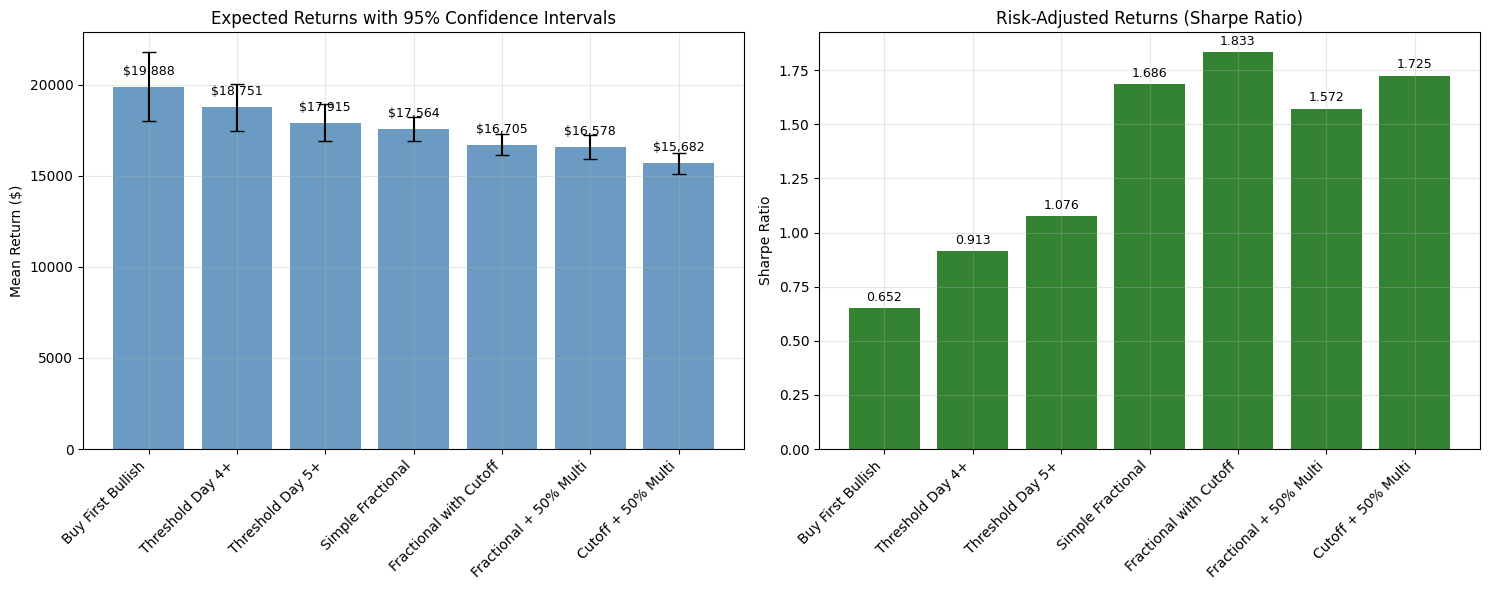

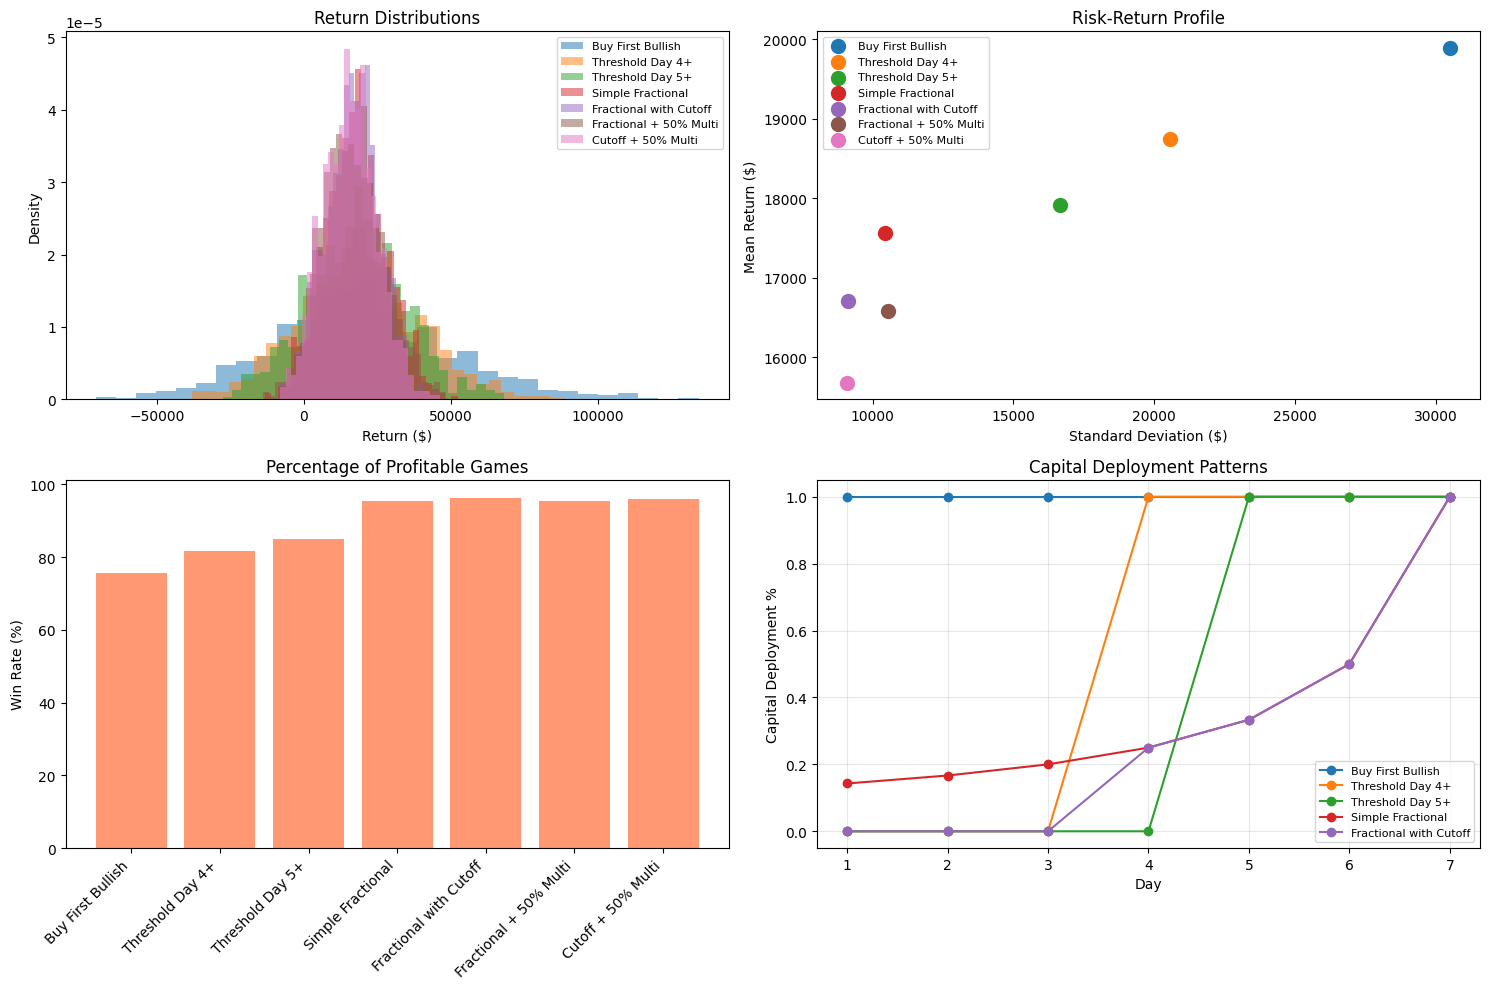



KEY INSIGHTS

Best Mean Return: Buy First Bullish
  - Expected return: $19,888.43
  - 95% CI: [$17,994.78, $21,782.07]

Best Sharpe Ratio: Fractional with Cutoff
  - Sharpe ratio: 1.833
  - Risk-adjusted performance leader

Highest Win Rate: Fractional with Cutoff
  - Win rate: 96.4%


Multiplier Effect Analysis:
----------------------------------------

Simple Fractional:
  Without multiplier: $17,564.05 (Sharpe: 1.686)
  With 50% multiplier: $16,577.66 (Sharpe: 1.572)
  Improvement: $-986.39

Fractional with Cutoff:
  Without multiplier: $16,704.99 (Sharpe: 1.833)
  With 50% multiplier: $15,681.99 (Sharpe: 1.725)
  Improvement: $-1,023.00


Statistical Significance Tests:
----------------------------------------

Threshold Day 4+ vs Day 5+: p-value = 0.3180
  Not significantly different at 95% confidence

Fractional vs Fractional+Multiplier: p-value = 0.0356
  Significantly different at 95% confidence


Example Game Walkthrough:
----------------------------------------

Strategy: B

In [7]:
# Cell 2: Execution - Run and Compare All Strategies

print("="*70)
print("STOCK MARKET GAME - CAPITAL DEPLOYMENT STRATEGY COMPARISON")
print("="*70)

# ==================== CREATE AND DISPLAY STRATEGIES ====================

print("\nCreating strategies...")
strategies = create_strategies()

# Display strategy details
print_strategy_details(strategies)

# ==================== RUN SIMULATIONS ====================

print("\n\nRunning simulations...")
print("-"*50)

# Initialize simulator
simulator = Simulator()

# Run evaluation for each strategy
results = []
n_episodes = 1000  # 1000 episodes for good statistical significance

for i, strategy in enumerate(strategies):
    print(f"\nEvaluating {strategy.name}... ", end="", flush=True)

    # Run evaluation
    result = simulator.evaluate_strategy(strategy, n_episodes=n_episodes)
    results.append(result)

    # Print summary
    print(f"Mean: ${result['mean_return']:,.2f}, Sharpe: {result['sharpe_ratio']:.3f}")

# ==================== DISPLAY RESULTS ====================

print("\n\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)

# Create results DataFrame
results_df = pd.DataFrame([{
    'Strategy': r['strategy'],
    'Mean Return': r['mean_return'],
    'Std Dev': r['std_dev'],
    'Sharpe Ratio': r['sharpe_ratio'],
    'Win Rate': r['positive_rate'] * 100,
    '95% CI Lower': r['ci_lower'],
    '95% CI Upper': r['ci_upper']
} for r in results])

# Sort by mean return
results_df = results_df.sort_values('Mean Return', ascending=False)

# Display formatted table
print("\nStrategy Performance (1,000 episodes each):")
print("-"*70)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}' if abs(x) > 1 else f'{x:.3f}')
print(results_df.to_string(index=False))

# ==================== MAIN COMPARISON PLOT ====================

print("\n\nGenerating comparison plots...")

# Main comparison plot (returns and Sharpe ratios)
summary_df = plot_strategy_comparison(results)

# ==================== DETAILED ANALYSIS ====================

# Additional detailed plots
plot_detailed_analysis(results)

# ==================== KEY INSIGHTS ====================

print("\n\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

# Find best performers
best_return_idx = results_df['Mean Return'].idxmax()
best_sharpe_idx = results_df['Sharpe Ratio'].idxmax()
best_win_rate_idx = results_df['Win Rate'].idxmax()

print(f"\nBest Mean Return: {results_df.loc[best_return_idx, 'Strategy']}")
print(f"  - Expected return: ${results_df.loc[best_return_idx, 'Mean Return']:,.2f}")
print(f"  - 95% CI: [${results_df.loc[best_return_idx, '95% CI Lower']:,.2f}, "
      f"${results_df.loc[best_return_idx, '95% CI Upper']:,.2f}]")

print(f"\nBest Sharpe Ratio: {results_df.loc[best_sharpe_idx, 'Strategy']}")
print(f"  - Sharpe ratio: {results_df.loc[best_sharpe_idx, 'Sharpe Ratio']:.3f}")
print(f"  - Risk-adjusted performance leader")

print(f"\nHighest Win Rate: {results_df.loc[best_win_rate_idx, 'Strategy']}")
print(f"  - Win rate: {results_df.loc[best_win_rate_idx, 'Win Rate']:.1f}%")

# ==================== MULTIPLIER EFFECT ANALYSIS ====================

print("\n\nMultiplier Effect Analysis:")
print("-"*40)

# Compare strategies with and without multiplier
base_fractional = next(r for r in results if r['strategy'] == 'Simple Fractional')
multi_fractional = next(r for r in results if r['strategy'] == 'Fractional + 50% Multi')

base_cutoff = next(r for r in results if r['strategy'] == 'Fractional with Cutoff')
multi_cutoff = next(r for r in results if r['strategy'] == 'Cutoff + 50% Multi')

print(f"\nSimple Fractional:")
print(f"  Without multiplier: ${base_fractional['mean_return']:,.2f} (Sharpe: {base_fractional['sharpe_ratio']:.3f})")
print(f"  With 50% multiplier: ${multi_fractional['mean_return']:,.2f} (Sharpe: {multi_fractional['sharpe_ratio']:.3f})")
print(f"  Improvement: ${multi_fractional['mean_return'] - base_fractional['mean_return']:,.2f}")

print(f"\nFractional with Cutoff:")
print(f"  Without multiplier: ${base_cutoff['mean_return']:,.2f} (Sharpe: {base_cutoff['sharpe_ratio']:.3f})")
print(f"  With 50% multiplier: ${multi_cutoff['mean_return']:,.2f} (Sharpe: {multi_cutoff['sharpe_ratio']:.3f})")
print(f"  Improvement: ${multi_cutoff['mean_return'] - base_cutoff['mean_return']:,.2f}")

# ==================== STATISTICAL SIGNIFICANCE ====================

print("\n\nStatistical Significance Tests:")
print("-"*40)

# Test if threshold strategies are significantly different
threshold4 = next(r for r in results if r['strategy'] == 'Threshold Day 4+')
threshold5 = next(r for r in results if r['strategy'] == 'Threshold Day 5+')

t_stat, p_value = stats.ttest_ind(threshold4['returns'], threshold5['returns'])
print(f"\nThreshold Day 4+ vs Day 5+: p-value = {p_value:.4f}")
print(f"  {'Significantly different' if p_value < 0.05 else 'Not significantly different'} at 95% confidence")

# Test multiplier effect significance
t_stat, p_value = stats.ttest_ind(base_fractional['returns'], multi_fractional['returns'])
print(f"\nFractional vs Fractional+Multiplier: p-value = {p_value:.4f}")
print(f"  {'Significantly different' if p_value < 0.05 else 'Not significantly different'} at 95% confidence")

# ==================== EXAMPLE GAME WALKTHROUGH ====================

print("\n\nExample Game Walkthrough:")
print("-"*40)

# Run one example game for the best strategy
best_strategy = strategies[results_df.index[0]]  # Best by mean return
example_game = StockMarketGame(seed=42)
state = example_game.reset()

print(f"\nStrategy: {best_strategy.name}")
print(f"Starting cash: ${state.cash:,.2f}")

total_invested = 0
done = False

while not done:
    valid_actions = example_game.get_valid_actions(state)
    actions = best_strategy.decide(state, valid_actions, example_game.config)

    if actions:
        print(f"\nDay {state.day}:")
        bullish_count = np.sum(state.tomorrows_movements == Movement.BULLISH.value)
        print(f"  Bullish stocks available: {bullish_count}")

        day_investment = 0
        for stock_idx, n_lots in actions.items():
            if n_lots > 0:
                cost = n_lots * 100 * state.prices[stock_idx]
                day_investment += cost
                print(f"  Buy {n_lots * 100} shares of Stock {stock_idx} for ${cost:,.2f}")

        total_invested += day_investment
        print(f"  Total invested this day: ${day_investment:,.2f}")

    state, reward, done = example_game.step(actions)

print(f"\nFinal portfolio value: ${state.get_portfolio_value():,.2f}")
print(f"Total invested: ${total_invested:,.2f}")
print(f"Final return: ${reward:,.2f}")

# ==================== RECOMMENDATIONS ====================

print("\n\n" + "="*70)
print("RECOMMENDATIONS")
print("="*70)

print("\n1. For Maximum Returns:")
print(f"   - Use '{results_df.iloc[0]['Strategy']}' strategy")
print(f"   - Expected annual return (52 weeks): ${results_df.iloc[0]['Mean Return'] * 52:,.2f}")

print("\n2. For Risk-Adjusted Performance:")
best_sharpe_row = results_df.loc[best_sharpe_idx]
print(f"   - Use '{best_sharpe_row['Strategy']}' strategy")
print(f"   - Lower volatility with good returns")
print(f"   - Sharpe ratio: {best_sharpe_row['Sharpe Ratio']:.3f}")

print("\n3. Key Findings:")
print("   - Waiting to deploy capital (Day 4+) generally improves returns")
print("   - Fractional deployment reduces volatility")
print("   - Multipliers for multiple bullish stocks reduce value")
print("   - The 'never buy' problem is completely avoided with these strategies")

print("\n" + "="*70)
print("Analysis complete!")
print("="*70)